<a href="https://colab.research.google.com/github/talisma-cassoma/ourmoney_desktop/blob/main/Exploratory_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Análise Financeira de Transações
Este notebook tem como objetivo analisar dados financeiros de transações para identificar padrões, tendências e áreas de volatilidade. As análises incluem:

1.  Visualização da distribuição de despesas e receitas por categoria.
2.  Comparação das despesas e receitas mensais.
3.  Identificação de categorias recorrentes de despesas.
4.  Previsão das despesas futuras usando regressão linear.
5.  Análise da variabilidade das categorias de despesas.
6.  Análise da correlação entre despesas e receitas mensais.

Com essa análise, buscamos responder a algumas perguntas chave:
1.  Quais são as categorias com maior volume de despesas e receitas?
2.  Quais categorias de despesas são mais recorrentes?
3.  É possível prever as despesas futuras por categoria?
4.  Quais categorias apresentam maior variabilidade e, portanto, são mais imprevisíveis?
5.  Existe alguma correlação entre despesas e receitas mensais?



In [112]:
# @title Expense Analysis Utilities
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression
import numpy as np
from scipy.stats import pearsonr, spearmanr, kendalltau
import matplotlib.pyplot as plt
from IPython.display import HTML, display
import seaborn as sns
import calendar
import warnings

warnings.filterwarnings('ignore')

class DataProcessor:
    """Handles data loading, cleaning, and preprocessing."""
    def __init__(self, file_path, sheet_name="Transactions"):
        self.file_path = file_path
        self.sheet_name = sheet_name
        self.df = self._load_and_clean_data()

    def _load_and_clean_data(self):
        """Loads data from Excel and performs initial cleaning."""
        df = pd.read_excel(self.file_path, sheet_name=self.sheet_name).copy()
        df = df.drop(columns={'id', 'owner', 'email', 'synced'})
        df['category'] = df['category'].astype(str).str.strip().str.lower()
        df['description'] = df['description'].astype(str).str.strip().str.lower()
        df['createdAt'] = pd.to_datetime(df['createdAt'], format='%d-%m-%Y', errors='coerce')
        df['month'] = df['createdAt'].dt.month
        return df

    def get_dataframe(self):
        """Returns the processed dataframe."""
        return self.df

class ExpenseAnalyzer:
    """Analyzes expenses data."""
    def __init__(self, dataframe):
        self.df = dataframe.copy()
        self.expenses_by_month = self._calculate_expenses_by_month()
        self.total_expenses_by_month = self._calculate_total_expenses_by_month()
        self._combine_expenses_data()
        self.time_period = -5  # Default time period
        self.last_months_expenses = self._filter_last_months_expenses()

    def _calculate_expenses_by_month(self):
      """Calculates expenses by month and category."""
      expenses = self.df[self.df['type'] == 'outcome'].groupby(['month', 'category'])['price'].sum().reset_index()
      return expenses

    def _calculate_total_expenses_by_month(self):
      """Calculates total expenses per month."""
      total_expenses = self.df[self.df['type'] == 'outcome'].groupby('month')['price'].sum().reset_index(name='Total month expense')
      return total_expenses

    def _combine_expenses_data(self):
        """Combines monthly expenses and total monthly expenses data."""
        self.expenses_by_month = self.expenses_by_month.merge(self.total_expenses_by_month, on='month', how='left')
        self.expenses_by_month['perc %'] = (self.expenses_by_month['price'] / self.expenses_by_month['Total month expense']) * 100
        month_map = {i: calendar.month_name[i] for i in range(1, 13)}
        self.expenses_by_month['month'] = self.expenses_by_month['month'].map(month_map)

    def _filter_last_months_expenses(self):
        """Filters expenses for the last few months based on the set time_period."""
        last_months = self.expenses_by_month['month'].unique()[self.time_period:]
        return self.expenses_by_month[self.expenses_by_month['month'].isin(last_months)]

    def get_expenses_by_month(self):
        """Returns the expenses by month."""
        return self.expenses_by_month

    def set_time_period(self, time_period):
      """Sets the time period for filtering last months."""
      if not isinstance(time_period, int):
         raise ValueError("time_period must be an integer")
      self.time_period = time_period


    def _month_order(self,month_name):
        """Helper function to get month order."""
        return list(calendar.month_name).index(month_name)

    def find_recurring_categories(self):
      """Identifies recurring expense categories in the last few months and returns a dataframe with months as columns."""
      last_months_expenses = self._filter_last_months_expenses()
      total_last_months = last_months_expenses['month'].nunique()

      # Identifying recurring categories
      recurring_categories = (
          last_months_expenses[last_months_expenses['price'] > 0]
          .groupby('category')['month']
          .nunique()
          .reset_index()
      )
      recurring_categories = recurring_categories[recurring_categories['month'] == total_last_months]

      # Get the expenses for recurring categories, pivoted by month
      recurring_expenses = last_months_expenses[last_months_expenses['category'].isin(recurring_categories['category'])]
      recurring_expenses_pivot = pd.pivot_table(
          recurring_expenses,
          index=['category'],
          columns=['month'],
          values='price',
          fill_value=0
      )

      # Map month numbers to month names
      month_map = {i: calendar.month_name[i] for i in range(1, 13)}
      self.expenses_by_month['month'] = self.expenses_by_month['month'].map(month_map)

      return recurring_expenses_pivot

class PivotTableVisualizer:
    """Generates and styles pivot tables."""
    def __init__(self, dataframe):
        self.df = dataframe.copy()

    def create_pivot_table(self):
        """Creates and styles a pivot table for expenses."""
        month_order = [calendar.month_name[i] for i in range(1, 13)]
        self.df['month'] = pd.Categorical(self.df['month'], categories=month_order, ordered=True)

        pivot_table = pd.pivot_table(
            self.df,
            index=['category'],
            columns=['month'],
            values=['price'],
            fill_value=0
        )
        styled_table = (
            pivot_table.style
            .format("{:.2f}")
            .background_gradient(cmap="coolwarm", axis=0)
            .set_caption("Annual Expenses by Category and Month")
            .set_table_styles([
                {'selector': 'caption', 'props': 'caption-side: top; font-size: 16px; font-weight: bold;'},
                {'selector': 'thead th', 'props': 'background-color: #f4f4f4; color: black; text-align: center;'},
                {'selector': 'th', 'props': 'font-size: 12px; text-align: center;'},
                {'selector': 'tbody th', 'props': 'border-bottom: 2px solid #000;'},
                {'selector': 'td, th', 'props': 'border-right: 1px solid #ddd;'},
                {'selector': 'th', 'props': 'border-left: 1px solid #ddd;'},
                {'selector': 'td', 'props': 'text-align: center; font-size: 11px;'},
            ])
        )
        return styled_table

class TransactionVisualizer:
    """Visualizes transaction data."""
    def __init__(self, dataframe):
      self.df = dataframe.copy()
      self.total_expenses,self.total_incomes = self._calculate_total()
      self.df_expenses_categories,self.df_incomes_categories = self._group_by_category()
      self.income_and_expenses_by_month = self._calculate_income_and_expenses_by_month()

    def _calculate_total(self):
      """Calculates total income and expenses."""
      total_by_type = self.df.groupby('type')['price'].sum().reset_index()
      total_expenses = total_by_type[total_by_type['type'] == 'outcome']['price'].iloc[0] if not total_by_type[total_by_type['type'] == 'outcome'].empty else 0
      total_incomes = total_by_type[total_by_type['type'] == 'income']['price'].iloc[0] if not total_by_type[total_by_type['type'] == 'income'].empty else 0

      return total_expenses, total_incomes

    def _group_by_category(self):
      """Groups transactions by category and calculates percentages."""
      df_expenses_categories = self.df[self.df['type'] == 'outcome'].groupby('category')['price'].sum().reset_index()
      df_expenses_categories['Perc % on expenses'] = (df_expenses_categories['price'] / self.total_expenses) * 100
      df_expenses_categories['Perc % on incomes'] = (df_expenses_categories['price'] / self.total_incomes) * 100

      df_incomes_categories = self.df[self.df['type'] == 'income'].groupby('category')['price'].sum().reset_index()
      df_incomes_categories['Perc % on incomes'] = (df_incomes_categories['price'] / self.total_incomes) * 100
      return df_expenses_categories,df_incomes_categories

    def _calculate_income_and_expenses_by_month(self):
      """Calculates total income and expenses by month."""
      income_and_expenses_by_month = self.df[self.df['type'] == 'outcome'].groupby(['month'])['price'].sum().reset_index()
      income_and_expenses_by_month = income_and_expenses_by_month.rename(columns={'price':'outcome price'}).copy()
      income_and_expenses_by_month['income price'] = self.df[self.df['type'] == 'income'].groupby(['month'])['price'].sum().reset_index()['price']
      month_map = {i: calendar.month_name[i] for i in range(1, 13)}
      income_and_expenses_by_month['month'] = income_and_expenses_by_month['month'].map(month_map)
      return income_and_expenses_by_month

    def plot_pie_expenses(self):
      """Plots a pie chart for expenses by category."""
      fig = px.pie(
          self.df_expenses_categories,
          names='category',
          values='Perc % on expenses',
          title='Distribuição de Despesas por Categoria',
          hole=0.3
      )
      fig.show()

    def plot_bar_incomes(self):
      """Plots a horizontal bar chart for incomes by category."""
      fig = px.bar(
          self.df_incomes_categories,
          x='Perc % on incomes',
          y='category',
          orientation='h',
          title='Percentual de Receitas por Categoria',
          labels={'Perc % on incomes': 'Percentual (%)', 'category': 'Categoria'},
          text='Perc % on incomes'
      )
      fig.update_traces(marker_color='rgb(56, 195, 225)', texttemplate='%{text:.2f}%', textposition='outside')
      fig.update_layout(xaxis_title='Percentual (%)', yaxis_title='Categoria')
      fig.show()

    def plot_combined_transactions(self):
      """Plots a grouped bar chart comparing expenses and incomes by category."""
      df_combined = pd.concat([self.df_expenses_categories.assign(type='Despesas'),
                         self.df_incomes_categories.assign(type='Receitas')])

      fig = px.bar(
          df_combined,
          x='category',
          y='price',
          color='type',
          barmode='group',
          title='Comparação de Despesas e Receitas por Categoria',
          labels={'price': 'Total (R$)', 'category': 'Categoria', 'type': 'Tipo de Transação'},
          text_auto=True
      )
      fig.update_layout(xaxis_title='Categoria', yaxis_title='Total (DH$)')
      fig.show()

    def plot_monthly_income_expenses(self):
        """Plots a grouped bar chart for monthly income and expenses."""
        fig = go.Figure()
        fig.add_trace(
            go.Bar(
                x=self.income_and_expenses_by_month['month'],
                y=self.income_and_expenses_by_month['outcome price'],
                name='Outcome Price',
                marker_color='red'
            )
        )
        fig.add_trace(
            go.Bar(
                x=self.income_and_expenses_by_month['month'],
                y=self.income_and_expenses_by_month['income price'],
                name='Income Price',
                marker_color='blue'
            )
        )
        fig.update_layout(
            title='Despesas e Receitas por Mês',
            xaxis_title='Mês',
            yaxis_title='Total (DH$)',
            barmode='group',
            legend_title='Tipo de Preço'
        )
        fig.show()

class CorrelationAnalyzer:
    """Analyzes correlation between two variables."""
    def __init__(self, dataframe):
      self.df = dataframe.copy()

    def analyze_correlation(self, x_var, y_var):
        """
        Analyzes the correlation between two variables in a pandas DataFrame.

        Parameters:
        dataframe (pd.DataFrame): The DataFrame containing the data.
        x_var (str): The name of the first variable (independent).
        y_var (str): The name of the second variable (dependent).

        Returns:
        dict: A dictionary containing Pearson's r, Spearman's rho, and Kendall's tau correlations.
        """
        # Calculate correlations
        pearson_corr, pearson_p = pearsonr(self.df[x_var], self.df[y_var])
        spearman_corr, spearman_p = spearmanr(self.df[x_var], self.df[y_var])
        kendall_corr, kendall_p = kendalltau(self.df[x_var], self.df[y_var])

        correlations = {
            "Pearson's r": (pearson_corr, pearson_p),
            "Spearman's rho": (spearman_corr, spearman_p),
            "Kendall's tau": (kendall_corr, kendall_p)
        }

        # Visualization
        plt.figure(figsize=(16, 6))

        # Scatterplot with regression line
        plt.subplot(1, 3, 1)
        sns.regplot(x=x_var, y=y_var, data=self.df, ci=None, scatter_kws={'alpha': 0.5})
        plt.title(f'Scatterplot of {x_var} vs {y_var}')
        plt.xlabel(x_var)
        plt.ylabel(y_var)

        # Heatmap of correlation matrix
        plt.subplot(1, 3, 2)
        corr_matrix = self.df[[x_var, y_var]].corr()
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
        plt.title('Correlation Matrix')

        # Pairplot for additional insights
        plt.subplot(1, 3, 3)
        sns.pairplot(self.df[[x_var, y_var]])
        plt.title('Pairplot')

        plt.tight_layout()
        plt.show()

        # Print correlation values
        print("Correlation Analysis:")
        print(f"Pearson's r: {pearson_corr:.2f}, p-value: {pearson_p:.2e}")
        print(f"Spearman's rho: {spearman_corr:.2f}, p-value: {spearman_p:.2e}")
        print(f"Kendall's tau: {kendall_corr:.2f}, p-value: {kendall_p:.2e}")

        return correlations

class TrendPredictor:
  """Predicts future trends using linear regression."""
  def __init__(self, dataframe):
    self.df = dataframe.copy()
  def predict_trends(self, time_period = -5):
        """
        Predicts future trends based on historical data using linear regression.

        Parameters:
          dataframe (pd.DataFrame): DataFrame with historical data, must have a 'month' column and numerical columns for analysis.
          time_period (int): define how many months to consider in the historical data
        Returns:
          pd.DataFrame: DataFrame with predicted values for each category.
        """

        last_months = self.df['month'].unique()[time_period:]
        df_last_months = self.df[self.df['month'].isin(last_months)].copy()

        month_to_number = {month: index + 1 for index, month in enumerate(df_last_months['month'].unique())}
        df_last_months['month_number'] = df_last_months['month'].map(month_to_number)


        predicted_values = []

        for category in df_last_months['category'].unique():

            df_category = df_last_months[df_last_months['category'] == category].copy()

            # Check for sufficient data points for regression
            if len(df_category) < 2:
                print(f"Not enough data points for linear regression for category {category}.")
                continue

            X = df_category['month_number'].values.reshape(-1, 1)
            y = df_category['price'].values

            model = LinearRegression()
            model.fit(X, y)

            # Make prediction for the next month
            next_month_number = df_category['month_number'].max() + 1

            predicted_value = model.predict(np.array([[next_month_number]]))[0]
            predicted_values.append({
                'category': category,
                'predicted_price': predicted_value
            })
        return pd.DataFrame(predicted_values)

class VariabilityAnalyzer:
    """Analyzes the variability of expenses."""
    def __init__(self, dataframe):
        self.df = dataframe.copy()
    def calculate_variability(self):
        """
        Calculates variance and coefficient of variation for each category.

        Returns:
            pd.DataFrame: DataFrame with variance and coefficient of variation for each category.
        """
        variability_data = []

        for category in self.df['category'].unique():
          df_category = self.df[self.df['category'] == category]['price']

          if len(df_category) < 2:
              variability_data.append({'category':category, 'variance': None,'coefficient_of_variation': None})
              continue
          variance = df_category.var()
          mean_value = df_category.mean()
          coef_variation = (np.sqrt(variance)/ mean_value ) if mean_value != 0 else np.nan

          variability_data.append({
            'category':category,
            'variance':variance,
            'coefficient_of_variation':coef_variation
          })
        return pd.DataFrame(variability_data)

In [119]:
# @title Load data
file_path = "/content/transactions.xlsx"
data_processor = DataProcessor(file_path)
df = data_processor.get_dataframe()
display(df.head(4).style.background_gradient())

,description,type,category,price,createdAt,month
0,vinho,outcome,bebida,34.500000,2024-12-20 00:00:00,12
1,gasosa e bolacha,outcome,extra,8.500000,2024-12-20 00:00:00,12
2,croissants e chips,outcome,extra,20.000000,2024-12-20 00:00:00,12
3,ida a embaixada,outcome,transporte,100.000000,2024-12-19 00:00:00,12


In [118]:
# @title Análise Exploratória
about_recurring_categories = """
<div>
<H2>verificando gastos recurrentes</H2>
<p>
Vamos começar explorando os dados, visualizando a distribuição de despesas por categoria, comparando<br>
despesas e receitas mensais e identificando categorias recorrentes nos últimos meses.</p>
</div>
"""
display(HTML(about_recurring_categories))

expense_analyzer = ExpenseAnalyzer(df)

#Set the number of months to filter
expense_analyzer.set_time_period(-3)
recurring_categories = expense_analyzer.find_recurring_categories()

display(recurring_categories.style.background_gradient())

about_annual_expenses_by_category = """
<div>
<H2>Análise Anual de Despesas por Categoria</H2>
<p>abaixo podemos visualizar da distribuição de despesas e receitas por categoria no ano.</p>
</div>
"""
display(HTML(about_annual_expenses_by_category))

pivot_table_visualizer = PivotTableVisualizer(expenses_by_month)
styled_pivot_table = pivot_table_visualizer.create_pivot_table()
display(styled_pivot_table)

month,December,November,October
category,,,
alimentaçao,1748.490000,1888.700000,1113.900000
aluguel,3100.000000,3100.000000,3100.000000
bebida,109.500000,832.500000,194.400000
casa,50.000000,1430.600000,145.000000
educaçao,650.000000,1000.000000,1378.000000
extra,227.000000,1028.800000,1198.500000
geovana,1028.000000,917.000000,149.000000
roupas,1325.000000,369.000000,140.000000
transporte,1643.000000,1474.000000,330.000000


In [69]:
# @title Análise Exploratória
transaction_visualizer = TransactionVisualizer(df)
print("Distribuição de despesas por categoria:")
transaction_visualizer.plot_pie_expenses()
print("Percentual de receitas por categoria:")
transaction_visualizer.plot_bar_incomes()
print("Comparação de despesas e receitas por categoria:")
transaction_visualizer.plot_combined_transactions()
print("Despesas e receitas mensais:")
transaction_visualizer.plot_monthly_income_expenses()

Distribuição de despesas por categoria:


Percentual de receitas por categoria:


Comparação de despesas e receitas por categoria:


Despesas e receitas mensais:


In [113]:
# @title Análise de Tendências
about_tendencies = """
<div>
<H2>Análise de Tendências</H2>
<p>Nesta seção, vamos usar regressão linear para projetar as despesas futuras por categoria.</p>
</div>
"""
display(HTML(about_tendencies))
trend_predictor = TrendPredictor(expenses_by_month)
predicted_trends = trend_predictor.predict_trends()
display(predicted_trends.style.background_gradient())

Not enough data points for linear regression for category calçados.
Not enough data points for linear regression for category kixikila.
Not enough data points for linear regression for category babysitting.
Not enough data points for linear regression for category gas.
Not enough data points for linear regression for category presentes.


,category,predicted_price
0,agua e luz,224.430000
1,alimentaçao,1522.842000
2,aluguel,3140.000000
3,angola,400.000000
4,ayla,755.000000
5,bebida,116.330000
6,casa,429.200000
7,estetica,10.750000
8,extra,293.202000
9,geovana,-772.300000


In [115]:
# @title Análise de Variabilidade
about_variability = """
<div>
<H2>Análise de Variabilidade</H2>
<p>Nesta seção, vamos analisar a variabilidade das despesas por categoria.<br>
vamos calcular a variância e o coeficiente de variação para identificar
as categorias menos previsíveis.</p>
</div>
"""
display(HTML(about_variability))

variability_analyzer = VariabilityAnalyzer(expenses_by_month)
variability = variability_analyzer.calculate_variability()
display(variability.style.background_gradient())

,category,variance,coefficient_of_variation
0,agua e luz,45798.425778,0.887013
1,alimentaçao,785607.171129,0.500186
2,aparelhos,492491.666667,1.550890
3,creche,800533.333333,0.882953
4,divida,1469204.166667,0.932988
5,extra,322636.682902,0.566658
6,internet,207935.401429,0.995601
7,presentes,6321.062500,0.947900
8,saude,486561.125714,0.827694
9,transporte,581481.018182,0.695930


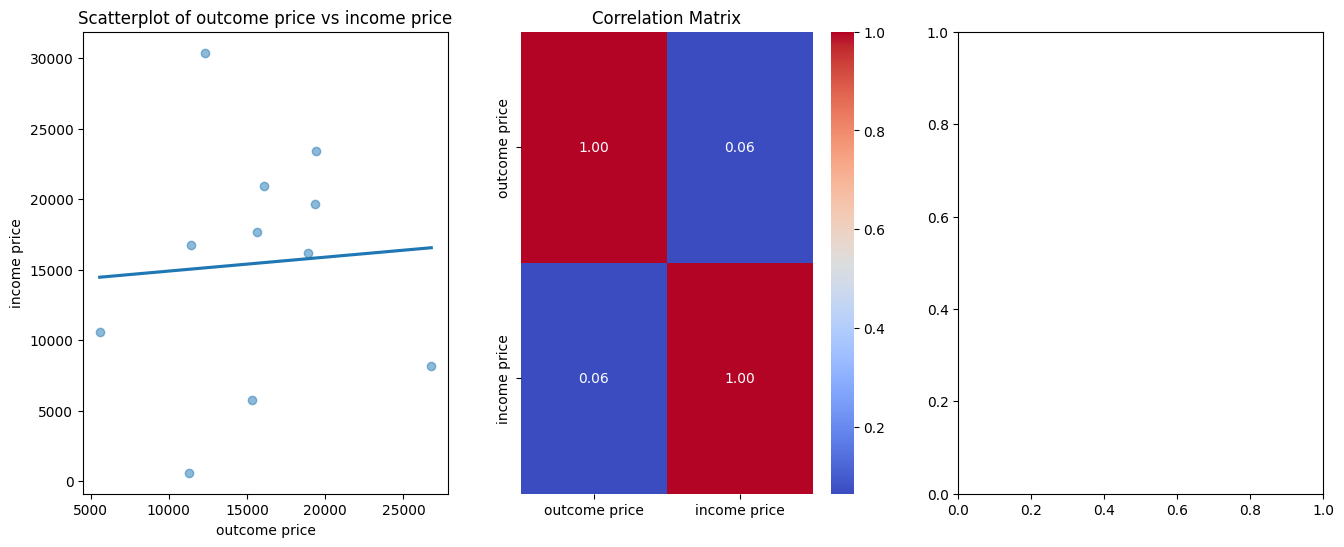

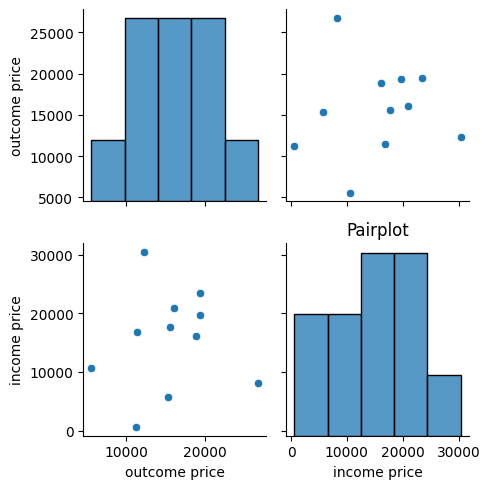

Correlation Analysis:
Pearson's r: 0.06, p-value: 8.51e-01
Spearman's rho: 0.29, p-value: 3.85e-01
Kendall's tau: 0.24, p-value: 3.59e-01


{"Pearson's r": (0.06443763826012971, 0.8507001760057481),
 "Spearman's rho": (0.29090909090909095, 0.38545696969136556),
 "Kendall's tau": (0.23636363636363636, 0.3587114698573032)}

In [39]:
# @title Análise de Correlação
"""
## Análise de Correlação
Vamos analisar a correlação entre despesas e receitas mensais.
"""
correlation_analyzer = CorrelationAnalyzer(transaction_visualizer.income_and_expenses_by_month)
correlation_analyzer.analyze_correlation('outcome price', 'income price')


## Conclusão

### Resumo das Principais Descobertas
1.  **Distribuição de Despesas e Receitas:** Os gráficos de pizza e barras revelaram as categorias com maior volume de despesas e receitas.
2.  **Categorias Recorrentes:** As categorias recorrentes nos últimos meses foram identificadas, mostrando as despesas mais consistentes.
3.  **Previsão de Despesas:** A análise de regressão linear forneceu uma projeção para as despesas do próximo mês para cada categoria.
4.  **Variabilidade das Categorias:** A análise de variabilidade identificou as categorias mais voláteis, ou seja, aquelas onde os gastos flutuam mais.
5.  **Correlação:** Foi investigada a correlação entre receitas e despesas, com os resultados apresentados em um gráfico de dispersão e matriz de correlação.

### Respostas às Perguntas Iniciais
1.  **Quais são as categorias com maior volume de despesas e receitas?** _(Resposta baseada nos gráficos gerados)._
2.  **Quais categorias de despesas são mais recorrentes?** _(Resposta baseada na saída do DataFrame `recurring_categories`)._
3.  **É possível prever as despesas futuras por categoria?** _Sim, por meio do método de regressão linear, que resultou nas predições mostradas acima._
4.  **Quais categorias apresentam maior variabilidade e, portanto, são mais imprevisíveis?** _(Resposta baseada na análise de variância e coeficiente de variação, no DataFrame `variability`)._
5.  **Existe alguma correlação entre despesas e receitas mensais?** _(Resposta baseada na análise de correlação, com valores apresentados em texto e gráfico)._
